In [2]:
# 신경망 구축과 데이터셋을 위한 torch, torchvision import

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

/opt/homebrew/anaconda3/envs/mlenv/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/anaconda3/envs/mlenv/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /opt/homebrew/anaconda3/envs/mlenv/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <EF59E044-2498-3CB6-AAE1-EEA304AC32DE> /opt/homebrew/anaconda3/envs/mlenv/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


In [4]:
# Local 경로 설정

%cd ~/Desktop/Dataset/Pytorch

/Users/one/Desktop/Dataset/Pytorch


In [16]:
# CIFAR10를 이용해 데이터셋 만들기

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='.data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# GPU 가속 사용 확인

device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f'{device} is available')

mps:0 is available


In [20]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 50, 5)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(50, 100, 5)
    self.pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(100*5*5, 120)
    self.fc2 = nn.Linear(120, 10)
    
  def forward(self, x):
    x = self.pool1(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    
    x = x.view(-1, 100*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    
    return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 50, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2500, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [22]:
loss_ = []
n = len(trainloader)

for epoch in range(10):
  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
  loss_.append(running_loss / n)
  print('[%d] loss %.3f' %(epoch + 1, running_loss / len(trainloader)))

[1] loss 1.623
[2] loss 1.140
[3] loss 0.938
[4] loss 0.794
[5] loss 0.686
[6] loss 0.588
[7] loss 0.504
[8] loss 0.427
[9] loss 0.350
[10] loss 0.282


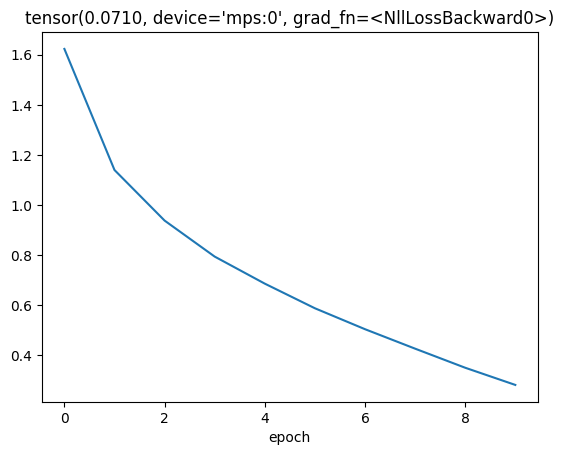

In [23]:
plt.plot(loss_)
plt.title(loss)
plt.xlabel('epoch')
plt.show()

In [24]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [25]:
net = Net().to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)

    total +=  labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'accuracy of 10000 test images : {100 * correct/total}%')

outputs.data

accuracy of 10000 test images : 73.95%


tensor([[ 0.6231,  0.0000,  2.2563, 15.5812,  0.8873, 12.0387,  6.6504,  3.3079,
          0.8636,  0.0000],
        [ 0.0000,  0.0000,  2.7730, 17.1278,  7.2599, 15.4875,  0.6205,  8.9887,
          2.2128,  0.0000],
        [ 0.0000,  2.7438,  6.3346, 15.4261,  8.4422, 10.5583,  4.0882,  5.9479,
          0.0000,  0.0000],
        [ 6.6183,  0.0000,  3.5039, 10.0291,  2.0126,  6.2569,  0.0000,  0.0000,
         12.2737,  0.0000],
        [ 0.0000,  0.0000,  8.9159, 15.0570, 11.5200, 15.5829, 10.6779,  5.8333,
          0.0000,  0.0000],
        [ 0.0000,  0.0000, 10.5801,  6.3605,  2.8322, 17.9010,  3.5694,  8.8531,
          1.1749,  0.0000],
        [ 7.3567,  3.7231,  0.5752,  1.9872,  9.8391,  2.9415,  0.5525,  2.2455,
          1.3513,  0.0000],
        [ 0.0000,  0.8199,  4.7166,  2.2805, 19.2337,  6.1509,  1.0657, 25.4271,
          0.0000,  0.0000]], device='mps:0')

In [27]:
predicted

tensor([3, 3, 3, 8, 5, 5, 4, 7], device='mps:0')